<a href="https://colab.research.google.com/github/Kulikov17/MLDS_DL/blob/main/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем датасет из kaggle

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c toxic-comments-classification-2023

  0% 0.00/1.52M [00:00<?, ?B/s]
100% 1.52M/1.52M [00:00<00:00, 107MB/s]


In [4]:
!unzip toxic-comments-classification-2023.zip

Archive:  toxic-comments-classification-2023.zip
  inflating: sample_submission.csv   
  inflating: test_data.csv           
  inflating: train_data.csv          


In [22]:
import pandas as pd
import numpy as np

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [27]:
RANDOM_SEED = 42

In [5]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [6]:
train.sample(3)

,comment,toxic
4801,А у нас и съезжать с дороги не надо.,0.0
5688,"Ну не знаю, в 89м всё было в дефиците.\n",0.0
7498,"И флаг погранцовский висит, не настоящий погра...",1.0


In [7]:
test.sample()

,comment_id,comment
430,430,"Алеша Лобстер, иди нахуй.\n"


Проверим, сбалансированы ли данные

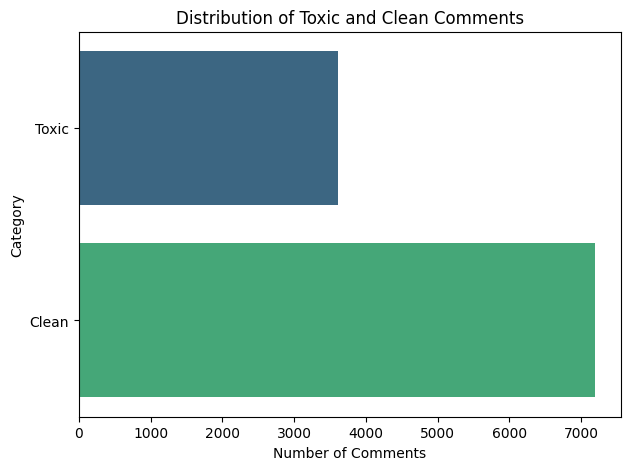

In [25]:
# Create subsets based on toxic and clean comments
train_toxic = train[train['toxic'] == 1]
train_clean = train[train['toxic'] == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')

# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Show the plot
plt.show()

Мы можем заметить, что наш набор данных сильно несбалансирован.

In [26]:
print(train_toxic.shape)
print(train_clean.shape)

(3608, 2)
(7201, 2)


Чтобы справиться с несбалансированными данными, мы можем создать новый обучающий набор, в котором количество токсичных комментариев останется прежним, и для соответствия этому мы случайным образом выберем 3608 чистых комментариев и включим их в обучающий набор.

In [28]:
train_clean_sampled = train_clean.sample(n=3608, random_state=RANDOM_SEED)

# Combine the toxic and sampled clean comments
train_balanced = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
train_balanced = train_balanced.sample(frac=1, random_state=RANDOM_SEED)

Для обучения модели разобьем train выборку на x_train и x_test, раскомментировав строчки кода в ячейке ниже:

In [34]:
x_train, x_test = train_test_split(train_balanced, test_size=0.2)

Попробуем реализовать подход с BERT

In [31]:
!wget https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_classifier.py
!wget https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_dataset.py

--2023-11-25 20:59:32--  https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_classifier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5278 (5.2K) [text/plain]
Saving to: ‘bert_classifier.py’

bert_classifier.py  100%[===================>]   5.15K  --.-KB/s    in 0s      

2023-11-25 20:59:33 (53.8 MB/s) - ‘bert_classifier.py’ saved [5278/5278]

--2023-11-25 20:59:33--  https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [tex

In [32]:
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

In [33]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=2,
        epochs=2,
        model_save_path='bert.pt'
)

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

In [35]:
classifier.preparation(
        X_train=list(x_train['comment']),
        y_train=list(x_train['toxic']),
        X_valid=list(x_test['comment']),
        y_valid=list(x_test['toxic'])
    )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
classifier.train()

Epoch 1/2


KeyboardInterrupt: ignored